Character-Level RNN: Text Generation from Asimov's *Foundation*

🧠 Goal:
Build a character-level RNN from scratch using NumPy to model language patterns in Isaac Asimov's *Foundation*.
The trained model will generate Asimov-style text one character at a time.

🔁 Plan:

1. 📖 Load and preprocess text
   - Read *Foundation* text
   - Create character-to-index (char2idx) and index-to-character (idx2char) mappings
   - Encode text as integer sequence

2. 🧱 Initialize RNN model
   - Parameters: Wxh, Whh, Why, bh, by
   - Hidden state size: e.g., 100

3. 🔄 Forward and Backward Pass
   - Implement one time-step forward: h_t = tanh(Wxh·x_t + Whh·h_{t-1} + bh)
   - Predict next char logits: y_t = Why·h_t + by
   - Use softmax + cross-entropy loss
   - Backpropagate gradients through time (BPTT)
   - Apply gradient clipping

4. 🏋️‍♂️ Training Loop
   - Slide a window over text with fixed sequence length (e.g., 25 chars)
   - Compute loss and gradients
   - Update parameters via SGD

5. 🧪 Sampling Function
   - Start from a seed character
   - Sample next character from softmax distribution
   - Repeat for N characters

6. 📉 Monitoring
   - Print loss every N steps
   - Print sample text every 1000 iterations

7. 🚀 [Optional] Try with different corpora (e.g., Sanskrit, Shakespeare)

This notebook is a stepping stone toward building a Sanskrit name generator using character-level RNNs.


In [8]:
import numpy as np

In [44]:
# ===========================
# 🔁 RNN FORWARD + BACKWARD MODULE
# Contains:
# - rnn_forward_backward(): forward and backward pass of a simple RNN
# - update_params(): SGD update with optional gradient clipping
# ===========================


def rnn_forward_backward(x_seq, y_seq, h_prev, params, vocab_size):
    """
    Perform a forward and backward pass of a vanilla RNN.
    
    Args:
        x_seq (list[int]): Sequence of input character indices.
        y_seq (list[int]): Sequence of target character indices.
        h_prev (np.ndarray): Hidden state from previous batch.
        params (dict): Dictionary of model parameters.
        vocab_size (int): Size of vocabulary.
        
    Returns:
        dict: Gradients for parameters, final hidden state, and total loss.
    """
    Wxh, Whh, Why = params['Wxh'], params['Whh'], params['Why']
    bxh, bhy = params['bxh'], params['bhy']

    seq_len = len(x_seq)
    h, y_pred, p, X = {}, {}, {}, {}
    h[-1] = h_prev
    loss = 0

    # FORWARD PASS
    for t in range(seq_len):
        X[t] = one_hot_encode([x_seq[t]], vocab_size)  # Shape: (vocab_size, 1)
        h[t] = np.tanh(np.dot(Wxh, X[t]) + np.dot(Whh, h[t - 1]) + bxh)
        y_pred[t] = np.dot(Why, h[t]) + bhy
        p[t] = np.exp(y_pred[t]) / np.sum(np.exp(y_pred[t]))  # softmax
        loss += -np.log(p[t][y_seq[t], 0])

    # BACKWARD PASS
    dWxh = np.zeros_like(Wxh)
    dWhh = np.zeros_like(Whh)
    dWhy = np.zeros_like(Why)
    dbxh = np.zeros_like(bxh)
    dbhy = np.zeros_like(bhy)
    dh_next = np.zeros_like(h[0])

    for t in reversed(range(seq_len)):
        dy = p[t].copy()
        dy[y_seq[t]] -= 1  # Gradient of cross-entropy loss
        dWhy += np.dot(dy, h[t].T)
        dbhy += dy

        dh = np.dot(Why.T, dy) + dh_next
        dtanh = (1 - h[t] ** 2) * dh  # Derivative of tanh
        dWxh += np.dot(dtanh, X[t].T)
        dWhh += np.dot(dtanh, h[t - 1].T)
        dbxh += dtanh
        dh_next = np.dot(Whh.T, dtanh)

    # Optional: Gradient clipping
    for dparam in [dWxh, dWhh, dWhy, dbxh, dbhy]:
        np.clip(dparam, -5, 5, out=dparam)

    return {
        'dWxh': dWxh,
        'dWhh': dWhh,
        'dWhy': dWhy,
        'dbxh': dbxh,
        'dbhy': dbhy,
        'loss': loss,
        'h_last': h[seq_len - 1]
    }


def update_params(params, grads, learning_rate):
    """
    Update RNN parameters using SGD.
    
    Args:
        params (dict): Model parameters.
        grads (dict): Corresponding gradients.
        learning_rate (float): Learning rate.
    """
    for param in params:
        # Clip gradients to prevent exploding gradients
        np.clip(grads[param], -5, 5, out=grads[param])
        # Update parameters using SGD
        params[param] -= learning_rate * grads[param]

In [25]:
# ------------------------
# Activation Functions
# ------------------------

def tanh(x):
    """Hyperbolic tangent activation."""
    return np.tanh(x)

def tanh_derivative(x):
    """Derivative of tanh for backpropagation."""
    return 1.0 - np.tanh(x) ** 2

def softmax(x):
    """Numerically stable softmax."""
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)

def softmax_with_temperature(x, temperature=1.0):
    """Softmax with temperature scaling."""
    scaled_x = x / temperature
    e_x = np.exp(scaled_x - np.max(scaled_x))  # numerical stability
    return e_x / np.sum(e_x)

# ------------------------
# One-Hot Encoding Utility
# ------------------------

def one_hot_encode(indices, vocab_size):
    """
    Convert list of indices to one-hot encoded 2D array.
    Each column represents one-hot encoding of a character.
    """
    result = np.zeros((vocab_size, len(indices)))
    for i, idx in enumerate(indices):
        result[idx, i] = 1
    return result

In [1]:
def initialize_rnn(hidden_size, vocab_size, seed=42, grad_clip=0.5):
    """
    Initialize RNN model parameters and training hyperparameters.

    Args:
        hidden_size (int): Number of neurons in the hidden layer.
        vocab_size (int): Size of the vocabulary (input and output dimension).
        seed (int): Random seed for reproducibility.

    Returns:
        params (dict): Dictionary of RNN weights and biases.
        hypers (dict): Dictionary of training hyperparameters.
    """
    np.random.seed(seed)

    # Xavier-like initialization with small random values
    params = {
        'Wxh': np.random.randn(hidden_size, vocab_size) * 0.01,       # Input-to-hidden weights
        'Whh': np.random.randn(hidden_size, hidden_size) * 0.01,      # Hidden-to-hidden weights
        'Why': np.random.randn(vocab_size, hidden_size) * 0.01,       # Hidden-to-output weights
        'bxh': np.zeros((hidden_size, 1)),                            # Hidden layer bias
        'bhy': np.zeros((vocab_size, 1)),                             # Output layer bias
    }

    # Training hyperparameters
    hypers = {
        'alpha': 5e-3,     # Learning rate (was tuned earlier)
        'seq_length': 50,  # Number of time steps per sequence
        'steps': 10000,    # Total number of training steps
        'grad_clip': grad_clip   # Gradient clipping threshold (optional to apply)
    }

    return params, hypers

In [13]:
# ===========================
# 📦 DATA PREP & BATCHING MODULE
# Contains:
# - get_vocab_mappings()
# - encode_data()
# - create_training_sequences()
# - batch_generator()
# ===========================

import numpy as np

def get_vocab_mappings(data):
    """
    Builds vocabulary and mapping dictionaries from input text data.
    
    Args:
        data (str): Entire text corpus
    
    Returns:
        Tuple[dict, dict, int]: char_to_ix, ix_to_char, vocab_size
    """
    chars = sorted(list(set(data)))
    vocab_size = len(chars)
    char_to_ix = {ch: i for i, ch in enumerate(chars)}
    ix_to_char = {i: ch for ch, i in char_to_ix.items()}
    return char_to_ix, ix_to_char, vocab_size

def encode_data(data, char_to_ix):
    """
    Encodes text data into a list of integer indices.
    
    Args:
        data (str): Raw text data
        char_to_ix (dict): Character-to-index mapping
    
    Returns:
        List[int]: Encoded text as indices
    """
    return [char_to_ix[ch] for ch in data]

def create_training_sequences(data_ix, seq_length=50, step=1):
    """
    Splits encoded data into overlapping sequences of length `seq_length`.
    
    Args:
        data_ix (List[int]): Encoded data indices
        seq_length (int): Length of each input sequence
        step (int): Stride between sequences
    
    Returns:
        Tuple[np.ndarray, np.ndarray]: Input and target sequences
    """
    X = []
    Y = []
    for i in range(0, len(data_ix) - seq_length, step):
        X.append(data_ix[i : i + seq_length])
        Y.append(data_ix[i + 1 : i + seq_length + 1])
    return np.array(X), np.array(Y)

def batch_generator(X_data, Y_data, batch_size):
    """
    Yields mini-batches of input-target pairs.
    
    Args:
        X_data (np.ndarray): Input sequences
        Y_data (np.ndarray): Target sequences
        batch_size (int): Number of sequences per batch
    
    Yields:
        Tuple[np.ndarray, np.ndarray]: Mini-batches
    """
    total_samples = len(X_data)
    for i in range(0, total_samples, batch_size):
        X_batch = X_data[i:i + batch_size]
        Y_batch = Y_data[i:i + batch_size]
        yield X_batch, Y_batch

# ✅ Example usage:
# char_to_ix, ix_to_char, vocab_size = get_vocab_mappings(data)
# data_ix = encode_data(data, char_to_ix)
# X_data, Y_data = create_training_sequences(data_ix, seq_length=50)
# for X_batch, Y_batch in batch_generator(X_data, Y_data, batch_size=64):
#     ...  # pass to training

In [21]:
# ===========================
# 🚂 TRAINING + SAMPLING LOOP
# Contains:
# - train_rnn(): main training loop
# - sample_rnn(): generate text using trained model
# ===========================

import time

def train_rnn(X_data, Y_data, params, hypers, char_to_ix, ix_to_char, print_every=100, start_text='A'):
    """
    Trains the RNN on input data using SGD.
    
    Args:
        data_ix (List[int]): Encoded character indices from text
        params (dict): Model parameters
        hypers (dict): Hyperparameters
        char_to_ix (dict): Character to index mapping
        ix_to_char (dict): Index to character mapping
        print_every (int): Print loss and sample text every `print_every` steps
        start_text (str): Seed text for sampling during training
    """
    vocab_size = len(char_to_ix)
    seq_length = hypers['seq_length']
    learning_rate = hypers['alpha']
    steps = hypers['steps']
    grad_clip = hypers['grad_clip']
    h_prev = np.zeros((params['Whh'].shape[0], 1))
    start_time = time.time()
    loss_history = []
    grad_norms = []
    
    
    for step in range(steps):
        i = step % len(X_data)
        x_seq = X_data[i]
        y_seq = Y_data[i]
        
        result = rnn_forward_backward(x_seq, y_seq, h_prev, params, vocab_size)
        h_prev = result['h_last']
        grads = {k: result['d' + k] for k in ['Wxh', 'Whh', 'Why', 'bxh', 'bhy']}
        update_params(params, grads, learning_rate)

        # Log loss and grad norm
        loss_history.append(result['loss'])
        total_grad_norm = np.sqrt(sum(np.sum(g**2) for g in grads.values()))
        grad_norms.append(total_grad_norm)
        
        if step % print_every == 0:
            elapsed = (time.time() - start_time) / 60
            print(f"Step {step} | Loss: {result['loss']:.4f} | Grad Norm: {total_grad_norm:.2f} | Time elapsed: {elapsed:.2f} min")
            #sample_text = sample_rnn(char_to_ix[start_text], h_prev, params, ix_to_char, n=300)
            #print("---- Sample ----")
            #print(sample_text)
            #print("----------------\n")

    return loss_history, grad_norms, params, h_prev

def sample_rnn(seed_ix, h_prev, params, ix_to_char, n=200, temperature=1.0):
    """
    Generates a text sequence using the trained RNN.
    
    Args:
        seed_ix (int): Index of the starting character
        h_prev (np.ndarray): Initial hidden state
        params (dict): RNN model parameters
        ix_to_char (dict): Mapping from index to character
        n (int): Number of characters to sample
        temperature (float): Sampling temperature
    
    Returns:
        str: Generated text
    """
    Wxh, Whh, Why = params['Wxh'], params['Whh'], params['Why']
    bxh, bhy = params['bxh'], params['bhy']
    
    vocab_size = Why.shape[0]
    h = h_prev
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1

    generated = []

    for _ in range(n):
        h = tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bxh)
        y = np.dot(Why, h) + bhy
        p = softmax_with_temperature(y, temperature)
        idx = np.random.choice(range(vocab_size), p=p.ravel())

        x = np.zeros((vocab_size, 1))
        x[idx] = 1
        generated.append(ix_to_char[idx])

    return ''.join(generated)


In [17]:
# Step 1: Load and preprocess text
import numpy as np

# Load cleaned Asimov corpus
with open("/kaggle/input/asimov/asimov_cleaned.txt", "r", encoding="utf-8") as f:
    data = f.read()

# Get all unique characters in the text
chars = sorted(list(set(data)))
vocab_size = len(chars)

# Create character-to-index and index-to-character mappings
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for ch, i in char_to_ix.items()}

# Encode the entire text as a list of character indices
data_ix = [char_to_ix[ch] for ch in data]

# Print some basic stats
print(f"Total characters: {len(data)}")
print(f"Unique characters: {vocab_size}")
print(f"Sample char_to_ix: {list(char_to_ix.items())[:10]}")
print(f"Encoded text (first 20 indices): {data_ix[:20]}")

Total characters: 10925424
Unique characters: 105
Sample char_to_ix: [(' ', 0), ('!', 1), ('"', 2), ('#', 3), ('$', 4), ('%', 5), ('&', 6), ("'", 7), ('(', 8), (')', 9)]
Encoded text (first 20 indices): [31, 72, 80, 68, 75, 81, 67, 68, 0, 39, 0, 68, 61, 82, 65, 0, 83, 78, 69, 80]


In [1]:
# Preprocessing
char_to_ix, ix_to_char, vocab_size = get_vocab_mappings(data)
data_ix = encode_data(data, char_to_ix)

# Create training sequences (do this once and reuse)
X_data, Y_data = create_training_sequences(data_ix, seq_length=hypers['seq_length'])

# Optionally save to disk
np.save("X_data.npy", X_data)
np.save("Y_data.npy", Y_data)

In [19]:
# Load training data
X_data = np.load("X_data.npy")
Y_data = np.load("Y_data.npy")

print("Loaded training data")

FileNotFoundError: [Errno 2] No such file or directory: 'X_data.npy'

In [39]:
experiments = []

import pickle

with open("experiments_asimov_rnn.pkl", "rb") as f:
    experiments = pickle.load(f)

In [4]:
# Initialize model
params, hypers = initialize_rnn(hidden_size=128, vocab_size=vocab_size, grad_clip=10.0)

# Train the model
loss_history, grad_norm, params, h_prev = train_rnn(
    X_data,
    Y_data,
    params,
    hypers,
    char_to_ix,
    ix_to_char,
    print_every=100,
    start_text="T"
)

experiments.append({
    'label': 'w Grad Clipping 10.0',
    'loss': loss_history,
    'grad_norms': grad_norm,
    'params': params,
    'h_last': h_prev
})



Step 0 | Loss: 232.6958 | Grad Norm: 12.02 | Time elapsed: 0.00 min
Step 100 | Loss: 136.5210 | Grad Norm: 50.44 | Time elapsed: 0.01 min
Step 200 | Loss: 138.1212 | Grad Norm: 27.18 | Time elapsed: 0.03 min
Step 300 | Loss: 131.5612 | Grad Norm: 29.24 | Time elapsed: 0.04 min
Step 400 | Loss: 135.5816 | Grad Norm: 21.51 | Time elapsed: 0.05 min
Step 500 | Loss: 98.2551 | Grad Norm: 30.69 | Time elapsed: 0.06 min
Step 600 | Loss: 98.2987 | Grad Norm: 143.19 | Time elapsed: 0.08 min
Step 700 | Loss: 89.9971 | Grad Norm: 119.89 | Time elapsed: 0.09 min
Step 800 | Loss: 59.3787 | Grad Norm: 113.76 | Time elapsed: 0.10 min
Step 900 | Loss: 31.2886 | Grad Norm: 49.52 | Time elapsed: 0.11 min
Step 1000 | Loss: 78.7860 | Grad Norm: 200.18 | Time elapsed: 0.13 min
Step 1100 | Loss: 57.2412 | Grad Norm: 85.16 | Time elapsed: 0.14 min
Step 1200 | Loss: 71.5215 | Grad Norm: 100.15 | Time elapsed: 0.15 min
Step 1300 | Loss: 29.6949 | Grad Norm: 45.50 | Time elapsed: 0.16 min
Step 1400 | Loss: 50.6

In [13]:
with open("experiments_asimov_rnn.pkl", "wb") as f:
    pickle.dump(experiments, f)

w/o Grad Clipping
w Grad Clipping 0.5
w Grad Clipping 1.0
w Grad Clipping 10.0


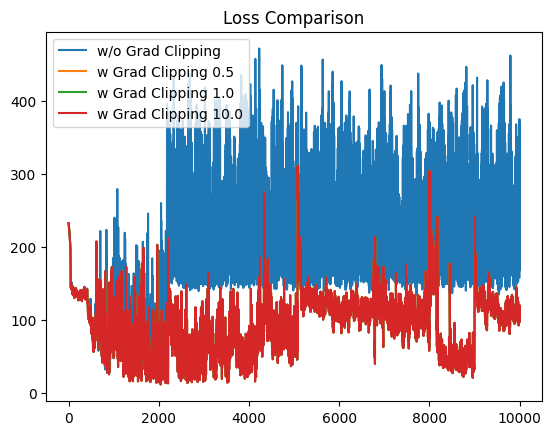

In [12]:
import matplotlib.pyplot as plt

for exp in experiments:
    print(exp['label'])
    plt.plot(exp['loss'], label=exp['label'])

plt.legend()
plt.title("Loss Comparison")
plt.show()

w/o Grad Clipping
w Grad Clipping


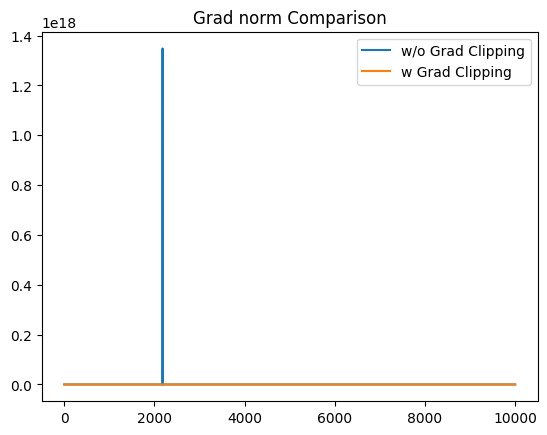

In [50]:
for exp in experiments:
    print(exp['label'])
    plt.plot(exp['grad_norms'], label=exp['label'])

plt.legend()
plt.title("Grad norm Comparison")
plt.show()

In [54]:
for exp in experiments:
    print(f"\n--- Sample from {exp['label']} ---")
    print(sample_rnn(char_to_ix['T'], exp['h_last'], exp['params'], ix_to_char))


--- Sample from w/o Grad Clipping ---
 gioaokieekuesioanoondgdeddiiaidanehaiaAenI  edduaeu ierseaetdundn geeefiiunie  eiiseireesgnsh nn geodeigss d eie aAgid node cneiskeean   dioun7d, hrinfesked nAgin  keaunhiAtviikiegdeednegAenehiee ikh

--- Sample from w Grad Clipping ---
 Ia thed threousid tor derirt, thacse tanitrtat afted bo iskto nonre the Tor,y fon, to ane torodiigatos ifithone the ce sertof I dhe, oovingtda,o fit oned,roto ied the ther tod thet ofedith waavsin bo


In [52]:
print(type(exp))         # Is it a list? a dict?
print(exp['label'])   

<class 'dict'>
w Grad Clipping
